# Forecasting

## Preparing data

In [1]:
import pandas as pd
df = pd.read_csv("../LTCUSDT.csv", parse_dates=["Date"])
df = df.iloc[::-1]
df

,Unix,Date,Symbol,Open,High,Low,Close,Volume LTC,Volume USDT,tradecount
2391,1513123200000,2017-12-13,LTCUSDT,272.00,330.00,260.00,290.01,9565.16019,2.770877e+06,4709
2390,1513209600000,2017-12-14,LTCUSDT,290.01,302.72,252.00,272.40,9631.98382,2.666481e+06,5753
2389,1513296000000,2017-12-15,LTCUSDT,272.40,314.21,239.99,294.00,16579.78235,4.658824e+06,7826
2388,1513382400000,2017-12-16,LTCUSDT,294.00,305.00,285.00,293.97,9102.10005,2.674492e+06,6151
2387,1513468800000,2017-12-17,LTCUSDT,293.01,328.80,290.00,311.40,14682.26118,4.618547e+06,10383
...,...,...,...,...,...,...,...,...,...,...
4,1719360000000,2024-06-26,LTCUSDT,71.35,71.95,70.36,71.02,286798.11800,2.044515e+07,74668
3,1719446400000,2024-06-27,LTCUSDT,71.02,73.35,70.55,73.28,300895.69100,2.160360e+07,73531
2,1719532800000,2024-06-28,LTCUSDT,73.28,74.76,72.54,72.90,412794.01800,3.038236e+07,110535
1,1719619200000,2024-06-29,LTCUSDT,72.90,76.90,72.87,74.95,348415.31500,2.609178e+07,95923


In [2]:
ltc_df = pd.DataFrame(df[["Date", "Close"]])
ltc_df

,Date,Close
2391,2017-12-13,290.01
2390,2017-12-14,272.40
2389,2017-12-15,294.00
2388,2017-12-16,293.97
2387,2017-12-17,311.40
...,...,...
4,2024-06-26,71.02
3,2024-06-27,73.28
2,2024-06-28,72.90
1,2024-06-29,74.95


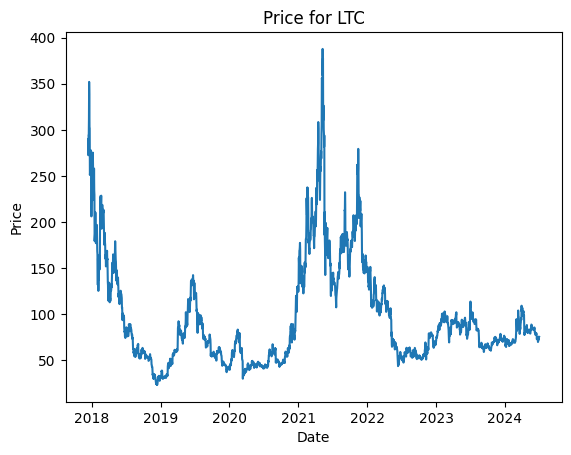

In [3]:
import matplotlib.pyplot as plt
ltc_df = ltc_df.rename({"Close": "Price"}, axis=1)

plt.plot(ltc_df["Date"], ltc_df["Price"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price for LTC");

## Split and create datasets

In [4]:
split_size = int(0.8*len(ltc_df))
X_train, X_test = ltc_df["Date"][:split_size], ltc_df["Date"][split_size:]
y_train, y_test = ltc_df["Price"][:split_size], ltc_df["Price"][split_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1913,), (479,), (1913,), (479,))

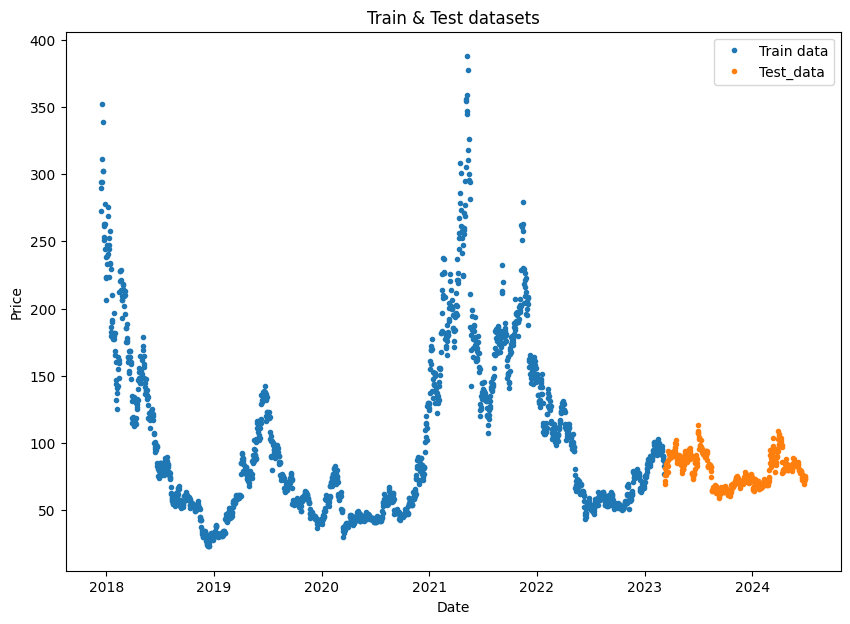

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train, '.', label="Train data")
plt.plot(X_test, y_test, '.', label="Test_data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Train & Test datasets")
plt.legend();

## Models

### Model 0: Naive Forecast

In [6]:
naive_forecast = y_test[:-1]
naive_forecast.shape

(478,)

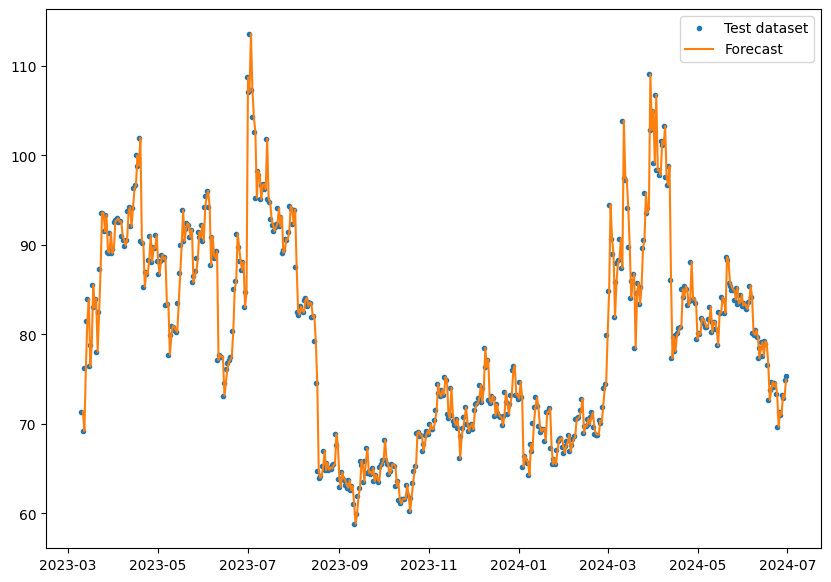

In [7]:
plt.figure(figsize=(10,7))
plt.plot(X_test, y_test, '.', label="Test dataset")
plt.plot(X_test[1:], naive_forecast, '-', label="Forecast")
plt.legend();

In [8]:
import tensorflow as tf
tf.keras.losses.mae(y_test[1:], naive_forecast)

2024-08-03 22:18:31.166354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 22:18:31.166437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 22:18:31.215478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 22:18:31.322108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 22:18:32.527883: W tensorflow/compiler/tf2

<tf.Tensor: shape=(), dtype=float64, numpy=1.9208786610878663>

In [9]:
# np.mean(np.abs(forecast - outsample)) / np.mean(np.abs(insample[:-frequency] - insample[frequency:]))
def mase(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    return tf.reduce_mean(tf.abs(y_true - y_pred)) / tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

In [10]:
mase(y_test[1:], naive_forecast).numpy()

1.000261

### Windowing dataset

In [11]:
import numpy as np
def get_labelled_windows(x, horizon=1):
    """
    Input: [price1, price2, price3, ... priceN] -> ([price1, price2, price3, ...], [priceN])
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    x = np.array(x)
    return x[:, :-horizon], x[:, -horizon:]

In [12]:
get_labelled_windows([[1, 2, 3, 4]])

(array([[1, 2, 3]]), array([[4]]))

In [13]:
import numpy as np

In [14]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [15]:
WINDOW_SIZE = 7
HORIZON_SIZE = 1

In [16]:
windows, labels = make_windows(ltc_df["Price"].to_numpy())

In [17]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [18]:
X_train, X_test, y_train, y_test = make_train_test_splits(windows, labels)
X_train

array([[290.01, 272.4 , 294.  , ..., 311.4 , 352.  , 338.48],
       [272.4 , 294.  , 293.97, ..., 352.  , 338.48, 302.7 ],
       [294.  , 293.97, 311.4 , ..., 338.48, 302.7 , 302.  ],
       ...,
       [ 95.39,  90.56,  89.34, ...,  87.36,  86.29,  82.76],
       [ 90.56,  89.34,  89.93, ...,  86.29,  82.76,  76.68],
       [ 89.34,  89.93,  87.36, ...,  82.76,  76.68,  71.37]])

In [19]:
# SOOOO 
# TODO: Is it harder to learn float16 rather then float32
#       Is it harder to learn rounded(3) rather then float16 

### Model 1: Base (float32)

In [20]:
from keras import layers
inputs = layers.Input((7), dtype=tf.float32)
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation='linear')(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(optimizer="Adam", loss="mae")

In [21]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
def best_model(name):
    return tf.keras.callbacks.ModelCheckpoint("checkpoints/" + name, verbose=0, save_weights_only=True, save_best_only=True, )

In [23]:
history_1 = model_1.fit(X_train, 
                        y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=1000, 
                        batch_size=128, 
                        verbose=0, 
                        callbacks=[best_model("base_model.weights.h5")])

2024-08-03 22:18:35.178693: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-03 22:18:35.377882: I external/local_xla/xla/service/service.cc:168] XLA service 0x7496390b3470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-03 22:18:35.377903: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-08-03 22:18:35.390841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-03 22:18:35.426292: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1722712715.517503    2274 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [24]:
model_1.load_weights("checkpoints/base_model.weights.h5")

In [25]:
preds = model_1.predict(X_test)
mase(y_test, preds)

15/15 [==============================] - 0s 994us/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.9982642>

### N-BEATS

In [26]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
import keras
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                input_size: int,
                theta_size: int,
                neurons: int,
                layers: int,
                horizon=1, 
                **kwargs):
        super().__init__(**kwargs)
        
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.neurons = neurons
        self.layers = layers

        self.hidden = [keras.layers.Dense(self.neurons, activation="relu") for _ in range(layers)]
        self.theta_layer = keras.layers.Dense(theta_size)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [28]:
WINDOW_SIZE  = 7 
HORIZON_SIZE = 1

In [29]:
block_layer = NBeatsBlock(
    input_size=WINDOW_SIZE,
    theta_size=WINDOW_SIZE+HORIZON_SIZE,
    layers=4,
    neurons=128,
    horizon=HORIZON_SIZE
)

In [30]:
inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [31]:
backcast, forecast = block_layer(inputs)
backcast, forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 0.14014898,  0.31812927,  0.1813275 ,  0.44213533,  0.13063875,
         -0.05698627,  0.3614439 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.2633477]], dtype=float32)>)

###### TASKS:
* Add Block reward to make the input 7 -> 7+block_reward
* Another input for block reward
* Block reward one hot input or not??
* Create Datasests with prefetch?
* add monthly or daily hashraite total mining

* Halving 2027 (Next LTC Halving) 3.125 LTC 30.07.2027
* Halving 2023 	2,520,000 	6.25 LTC 	August 2, 2023
* Halving 2019 	1,680,000 	12.5 LTC 	August 5, 2019
* Halving 2015 	840,000 	25 LTC 	August 25, 2015
* 2011 	0 (Genesis Block) 	50 LTC 	October 7, 2011

In [32]:
block_rewards = {
    pd.Timestamp(2015, 8, 25): 25,
    pd.Timestamp(2019, 8, 5): 12.5,
    pd.Timestamp(2023, 8, 2): 6.25
}
block_rewards

{Timestamp('2015-08-25 00:00:00'): 25,
 Timestamp('2019-08-05 00:00:00'): 12.5,
 Timestamp('2023-08-02 00:00:00'): 6.25}

In [33]:
c = list(block_rewards.keys())
print(abs(c[0] - c[1]))


1441 days 00:00:00


In [34]:
windows_block = windows
windows_block

array([[290.01, 272.4 , 294.  , ..., 311.4 , 352.  , 338.48],
       [272.4 , 294.  , 293.97, ..., 352.  , 338.48, 302.7 ],
       [294.  , 293.97, 311.4 , ..., 338.48, 302.7 , 302.  ],
       ...,
       [ 74.17,  74.61,  73.37, ...,  71.35,  71.02,  73.28],
       [ 74.61,  73.37,  69.68, ...,  71.02,  73.28,  72.9 ],
       [ 73.37,  69.68,  71.35, ...,  73.28,  72.9 ,  74.95]])

In [35]:
c = np.array(np.arange(12)+1).reshape(4, 3)
np.insert(c[1:3], 1, 7, axis=1)

array([[4, 7, 5, 6],
       [7, 7, 8, 9]])

In [36]:
block_reward_df = pd.DataFrame(columns=["Reward"])
for i in block_rewards:
    days = ltc_df["Date"][len(ltc_df)-1] - i
    print(days)

841 days 00:00:00
-600 days +00:00:00
-2058 days +00:00:00


### Preparing data for the N-BEATS algo using `tf.data`

In [37]:
ltc_df_nbeats = ltc_df.copy()
ltc_df_nbeats = ltc_df_nbeats.drop("Date", axis=1) 
for i in range(WINDOW_SIZE):
    ltc_df_nbeats[f"Price+{i+1}"] = ltc_df_nbeats["Price"].shift(periods=i+1)
ltc_df_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
2391,290.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2390,272.40,290.01,NaN,NaN,NaN,NaN,NaN,NaN
2389,294.00,272.40,290.01,NaN,NaN,NaN,NaN,NaN
2388,293.97,294.00,272.40,290.01,NaN,NaN,NaN,NaN
2387,311.40,293.97,294.00,272.40,290.01,NaN,NaN,NaN
2386,352.00,311.40,293.97,294.00,272.40,290.01,NaN,NaN
2385,338.48,352.00,311.40,293.97,294.00,272.40,290.01,NaN
2384,302.70,338.48,352.00,311.40,293.97,294.00,272.40,290.01
2383,302.00,302.70,338.48,352.00,311.40,293.97,294.00,272.40
2382,250.99,302.00,302.70,338.48,352.00,311.40,293.97,294.00


In [38]:
X = ltc_df_nbeats.dropna().drop("Price", axis=1)
y = ltc_df_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test = y[:split_size], y[split_size:]
X_train, X_test,y_train, y_test

(      Price+1  Price+2  Price+3  Price+4  Price+5  Price+6  Price+7
 2384   338.48   352.00   311.40   293.97   294.00   272.40   290.01
 2383   302.70   338.48   352.00   311.40   293.97   294.00   272.40
 2382   302.00   302.70   338.48   352.00   311.40   293.97   294.00
 2381   250.99   302.00   302.70   338.48   352.00   311.40   293.97
 2380   253.44   250.99   302.00   302.70   338.48   352.00   311.40
 ...       ...      ...      ...      ...      ...      ...      ...
 481     87.36    89.93    89.34    90.56    95.39    97.78    93.80
 480     86.29    87.36    89.93    89.34    90.56    95.39    97.78
 479     82.76    86.29    87.36    89.93    89.34    90.56    95.39
 478     76.68    82.76    86.29    87.36    89.93    89.34    90.56
 477     71.37    76.68    82.76    86.29    87.36    89.93    89.34
 
 [1908 rows x 7 columns],
      Price+1  Price+2  Price+3  Price+4  Price+5  Price+6  Price+7
 476    69.21    71.37    76.68    82.76    86.29    87.36    89.93
 475    

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1024).prefetch(tf.data.AUTOTUNE)

In [40]:
# Values from N-BEATS paper
EPOCHS  = 5000
NEURONS = 512
LAYERS  = 4
STACKS  = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON_SIZE

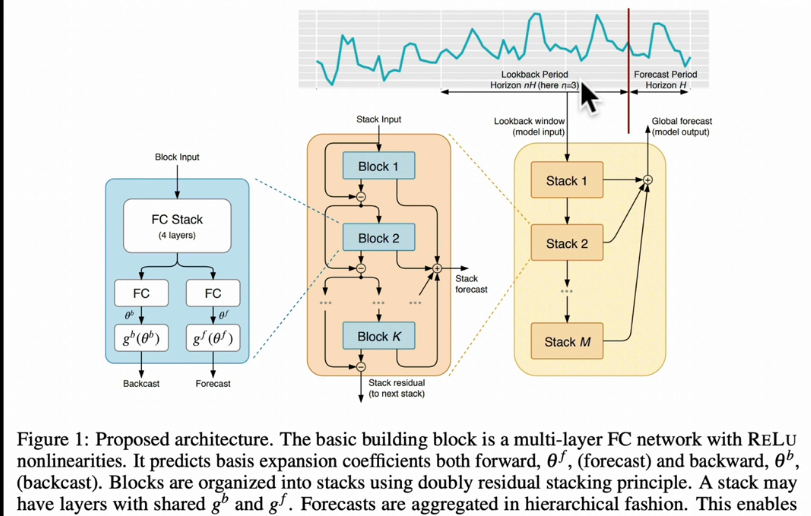

### Getting  ready for the resodual connections

In [41]:
tensor_1 = tf.range(10) + 1
tensor_2 = tf.range(10)

In [42]:
keras.layers.subtract([tensor_1, tensor_2]), \
keras.layers.add([tensor_1, tensor_2])

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19], dtype=int32)>)

https://paperswithcode.com/method/resnet

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this will be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. use `for` loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which will return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together..
8. Compile with MAE and Adam lr=0.001
9. Fit the model for 5000 epochs with
    * EarlyStopping
    * Reduce the LR on Plateau

In [56]:
%%time 

tf.random.set_seed(42)

# 1.
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                theta_size=THETA_SIZE,
                                horizon=HORIZON_SIZE,
                                neurons=NEURONS,
                                layers=LAYERS,
                                name="InitialBlock")

# 2.
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. 
residuals, forecast = nbeats_block_layer(stack_input)

# 4.
for i, _ in enumerate(range(STACKS - 1)): # first stack is already created so -1
    # 5.
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON_SIZE,
        neurons=NEURONS,
        layers=LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) # <--

    # 6.
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7.
nbeats_model = tf.keras.Model(stack_input, forecast, name="NBEATS")

# 8.
nbeats_model.compile(optimizer="Adam", loss="mae")

# 9.
n_beats_history = nbeats_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=200,
                                               restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(patience=100,
                                                  verbose=1)]
)


Epoch 297: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 397: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 38s, sys: 4.5 s, total: 1min 43s
Wall time: 2min 7s


In [54]:
mase(y_test, nbeats_model.evaluate(test_dataset))

1/1 [==============================] - 0s 29ms/step - loss: 1.9064


<tf.Tensor: shape=(), dtype=float32, numpy=40.616287>

### Plotting the N-BEATS architecture we have created

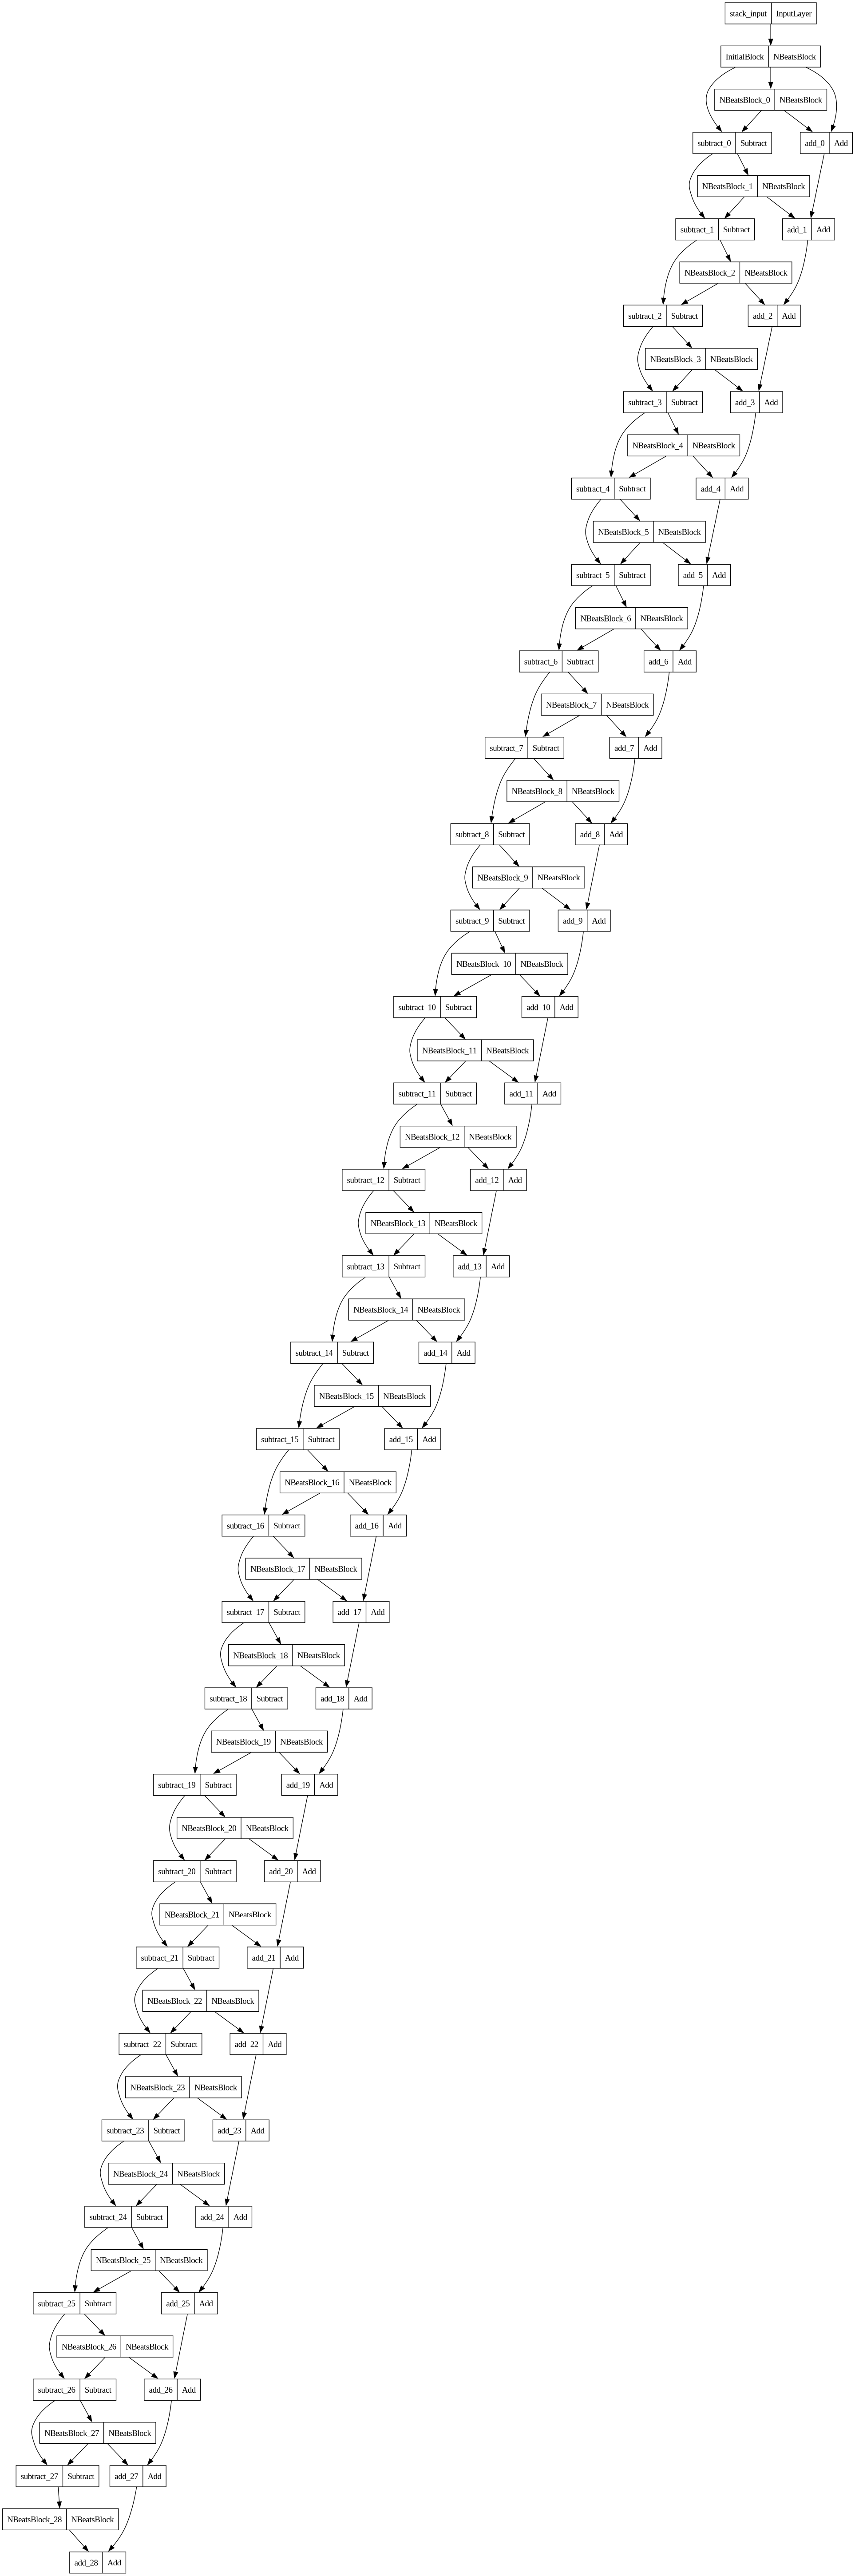

In [57]:
keras.utils.plot_model(nbeats_model)

In [58]:
nbeats_model.summary()

Model: "NBEATS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stack_input (InputLayer)    [(None, 7)]                  0         []                            
                                                                                                  
 InitialBlock (NBeatsBlock)  ((None, 7),                  796168    ['stack_input[0][0]']         
                              (None, 1))                                                          
                                                                                                  
 NBeatsBlock_0 (NBeatsBlock  ((None, 7),                  796168    ['InitialBlock[0][0]']        
 )                            (None, 1))                                                          
                                                                                             